In [594]:
%load_ext autoreload
%autoreload 2


In [1]:
import pandas as pd

In [872]:
import datetime as dt

In [37]:
import matplotlib.pyplot as plt

In [3]:
! wc -l "./DataTask/Data/OrderItems.txt"

3365398 ./DataTask/Data/OrderItems.txt


In [4]:
orders_df = pd.read_csv("./DataTask/Data/OrderEntry.txt")

In [8]:
orders_df['Order Date'] = pd.to_datetime(orders_df['TransDate']).dt.date

In [209]:
lines = []
header = None

with open('./DataTask/Data/OrderItems.txt', 'r') as f:
    for i, line in enumerate(f):
        if i == 0:
            header = line[:-1].split(',')
            continue
        parts = line[:-1].split(',')
        parts = parts[:4] + [",".join(parts[4:-3])] + parts[-3:]
        
        assert len(parts) == 8, line
        
        lines.append(parts)

In [219]:
order_items_df = pd.DataFrame(lines, columns=header)

In [221]:
for column in order_items_df.columns:
    if column in ['Description']:
        continue
    order_items_df.loc[
        order_items_df[column] == '',
        column
    ] = None
    order_items_df[column] = order_items_df[column].astype(float)

In [223]:
merged_orders_df = order_items_df.merge(
    orders_df[['ID', 'Customer', 'Order Date']],
    left_on=['OrderNumber'],
    right_on=['ID'],
    suffixes=('', '_order')
)

In [870]:
max_date = merged_orders_df['Order Date'].max()

In [878]:
monthly_orders_df = merged_orders_df[
    merged_orders_df['Order Date'] > max_date - dt.timedelta(days=30)
].copy()

In [881]:
lifetime_df = merged_orders_df.groupby('Customer').agg({
    'Order Date': ['min', 'max']
})

In [885]:
lifetime_df.columns = ['min_day', 'max_day']

In [886]:
lifetime_df['lifetime'] = (lifetime_df['max_day'] - lifetime_df['min_day']).dt.total_seconds() // (60 * 60 * 24) + 1

In [882]:
users_df = monthly_orders_df.groupby('Customer').agg({
    'OrderNumber': 'nunique',
    'Qty': 'sum',
    'Retail': 'sum',
    'MenuItemID': 'nunique',
    'Order Date': 'nunique'
})

In [887]:
users_df.columns = ['orders', 'items', 'price', 'unique_items', 'active_days']

In [888]:
users_df['lifetime'] = lifetime_df['lifetime']

In [889]:
users_df['avg_order'] = users_df['price'] / users_df['orders']

In [890]:
users_df['items_per_order'] = users_df['items'] / users_df['orders']

In [891]:
users_df['unique_items_per_order'] = users_df['unique_items'] / users_df['orders']

In [955]:
users_df = users_df[
    users_df['price'] != 0
].copy()

Признаки кластеризации:
- Количество заказов
- Средний размер заказа
- Средний чек
- Частота использования сервиса
- Лайфтайм
- Количество дней с заказами
- Повышение активности в последний месяц

# Кластеризация

# Распределение признаков

In [1192]:
import numpy as np

In [1193]:
from sklearn.cluster import KMeans

In [1194]:
from sklearn.preprocessing import StandardScaler

In [1195]:
features = [
#     'orders',
#     'items',
#     'price',
#     'unique_items',
#     'min_day',
#     'max_day',
    'active_days',
    'avg_order',
    'items_per_order',
    'unique_items_per_order',
    'lifetime'
]

In [1196]:
pd.options.display.float_format = '{:,.2f}'.format

In [1197]:
users_df[features].head(5)

,active_days,avg_order,items_per_order,unique_items_per_order,lifetime
0,3,"1,496.67",2.33,1.67,343.00
1,1,950.00,2.00,1.00,958.00
2,6,"1,781.67",6.67,2.67,974.00
3,1,"1,560.00",4.00,4.00,936.00
4,2,"2,350.00",3.50,2.50,967.00


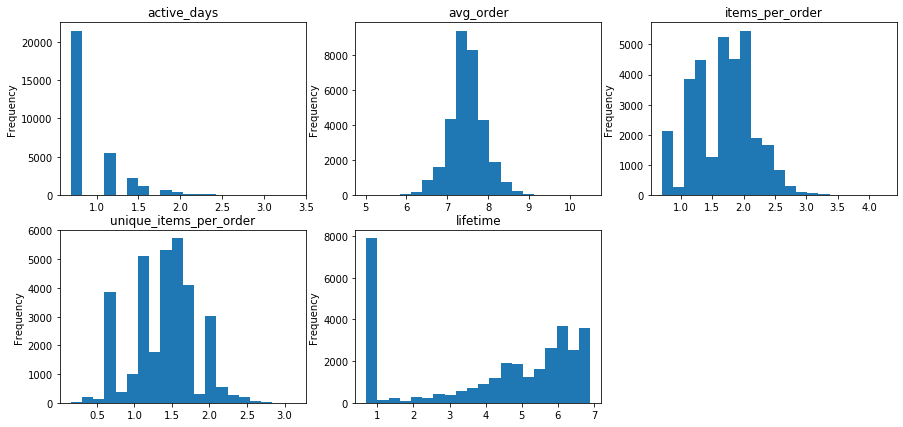

In [1199]:
plt.figure(figsize=(15, 7))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    np.log(users_df[feature] + 1).plot(kind='hist', bins=20)
    plt.title(feature)
#     plt.show()#= users_df[feature]

In [1190]:
users_df['one_day_user'] = (users_df['lifetime'] == 1)

In [962]:
users_df['one_day_user'].value_counts()

False    24208
True      7898
Name: one_day_user, dtype: int64

In [963]:
features.append('one_day_user')

In [964]:
features

['active_days',
 'avg_order',
 'items_per_order',
 'unique_items_per_order',
 'lifetime',
 'one_day_user']

In [965]:
users_df = users_df.reset_index(drop=True)

# Кластеризация

In [966]:
users_prepared_df = users_df[features].copy()

In [967]:
for feature in users_prepared_df[features]:
    if feature not in ['one_day_user']:
        users_prepared_df[feature] = np.log(users_prepared_df[feature] + 1)

In [968]:
scaler = StandardScaler()

In [969]:
# users_prepared_scaled_df = pd.DataFrame(
#     scaler.fit_transform(users_prepared_df), 
#     columns=list(users_prepared_df.columns), 
#     index=users_prepared_df.index
# )
users_prepared_scaled_df = users_prepared_df

In [970]:
clustering = KMeans(n_clusters=7)

In [971]:
clustering.fit(users_prepared_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [972]:
users_df["cluster"] = clustering.predict(users_prepared_scaled_df)

In [973]:
users_prepared_scaled_df.quantile(0.99)

active_days               2.297317
avg_order                 8.662332
items_per_order           2.772589
unique_items_per_order    2.302585
lifetime                  6.842683
one_day_user              1.000000
Name: 0.99, dtype: float64

In [974]:
users_df['cluster'].value_counts()

1    7298
4    6147
5    4580
6    4020
3    3847
2    3661
0    2553
Name: cluster, dtype: int64

In [975]:
clusters = users_df["cluster"].unique()

# Визуализация

In [976]:
from sklearn.decomposition import PCA

In [977]:
pca = PCA(n_components=2)

In [978]:
users_pca = pca.fit_transform(users_prepared_scaled_df)

In [979]:
pca.explained_variance_ratio_

array([0.87249881, 0.06603324])

In [980]:
users_pca.shape

(32106, 2)

In [981]:
users_pca_df = pd.DataFrame(users_pca, columns=["x", "y"])

In [982]:
users_pca_df['cluster'] = users_df["cluster"].apply(lambda x: "c" + str(x))

In [983]:
users_pca_df['cluster'].value_counts()

c1    7298
c4    6147
c5    4580
c6    4020
c3    3847
c2    3661
c0    2553
Name: cluster, dtype: int64

In [984]:
import seaborn as sns

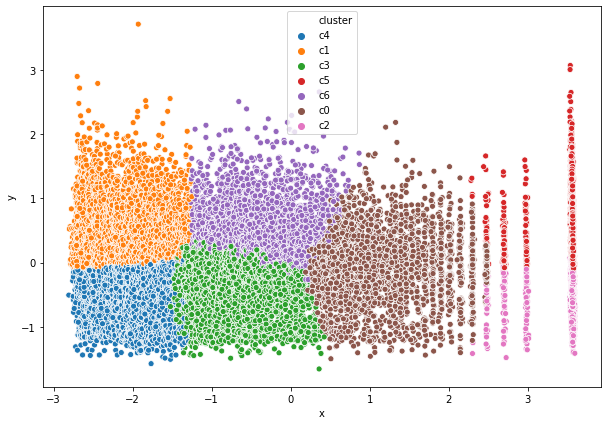

In [988]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=users_pca_df,
    x="x",
    y="y",
    hue="cluster"
)

# Интерпретация кластеров

In [989]:
from explanation import ClustersExplanation

Нужно показать, какие именно интерпретации получились

In [1034]:
np.linspace(0, 0.3, 26)

array([0.   , 0.012, 0.024, 0.036, 0.048, 0.06 , 0.072, 0.084, 0.096,
       0.108, 0.12 , 0.132, 0.144, 0.156, 0.168, 0.18 , 0.192, 0.204,
       0.216, 0.228, 0.24 , 0.252, 0.264, 0.276, 0.288, 0.3  ])

In [1163]:
explanation = ClustersExplanation(
    clusters, 
    features,
    thresholds=np.linspace(0, 0.4, 26)
)

In [1164]:
explanation.fit(users_df)

In [1165]:
explanation.score()

1.0

In [1166]:
pd.DataFrame(explanation.explain())

,feature,lower_part,threshold,value,upper_part
0,active_days,"[5, 6, 2]",0.37,1.00,[0]
1,avg_order,[0],0.40,"1,815.50",[1]
2,items_per_order,"[4, 3, 2]",0.19,4.33,"[1, 5, 6]"
3,unique_items_per_order,"[4, 3, 2]",0.35,2.12,[0]
4,lifetime,"[3, 6]",0.03,241.00,"[4, 1]"
5,one_day_user,"[4, 1, 3, 6, 0]",0.05,0.00,"[5, 2]"


In [1151]:
rule_interpretation = [
    ('inactive', ''),
    ('low-spending', ''),
    ('', 'mass-buying'),
    ('single-minded', ''),
    ('fresh', 'experienced'),
    ('returning', 'first-time')
]

In [1167]:
explanation.get_legend(rule_interpretation)

inactive /  : active_days < 1.000 for 63.2% of cluster
low-spending /  : avg_order < 1815.500 for 60.0% of cluster
 / mass-buying : items_per_order > 4.333 for 80.8% of cluster
single-minded /  : unique_items_per_order < 2.125 for 64.8% of cluster
fresh / experienced : lifetime < 241.000 for 96.8% of cluster
returning / first-time : one_day_user < 0.000 for 95.2% of cluster


In [1153]:
explanation_dict = explanation.get_cluster_names(rule_interpretation)
explanation_dict

{4: 'Single-minded experienced returning users',
 1: 'Mass-buying experienced returning users',
 3: 'Single-minded fresh returning users',
 5: 'Inactive mass-buying first-time users',
 6: 'Inactive mass-buying fresh returning users',
 0: 'Low-spending returning users',
 2: 'Inactive single-minded first-time users'}

In [1154]:
users_pca_df['cluster_label'] = users_df['cluster'].apply(explanation_dict.get)

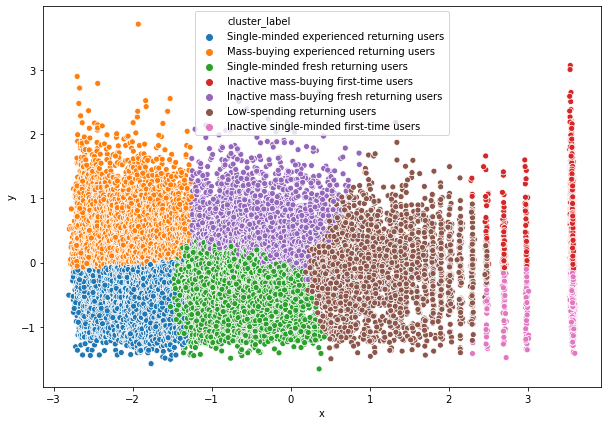

In [1155]:
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=users_pca_df,
    x="x",
    y="y",
    hue="cluster_label"
)